# Spectral Frame Conversion Demo

[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/imaging/msv4_spectral_frame_conversion_demo_comparison.ipynb)


## Install AstroVIPER

Skip this cell if you don't want to install the latest version of AstroVIPER.

In [ ]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")
    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

Using xradio version 0.0.29


In [2]:
import sys
sys.path.append('../src/')
from astroviper.core.visibility_manipulation.ms_spectral_frame_conversion import ms_spectral_frame_conversion
import xradio
from xradio.measurement_set import open_processing_set
from astropy.time import Time
import numpy as np
import xarray as xr
import matplotlib.pylab as pl

## Get data
Lets get the ms v4 data sets 
One is in topo and one has been processed by casa6 to compare results 


In [3]:
from toolviper.utils.data import download
download(file="Antennae_fld1_topo.ps.zarr")
download(file="Antennae_fld1_casa_lsrk.ps.zarr")

[2025-09-16 11:47:22,639]     INFO    viperlog:  Module path: /Users/jsteeb/Dropbox/toolviper/src/toolviper 
[2025-09-16 11:47:22,642]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List               
 ──────────────────────────── 
  Antennae_fld1_topo.ps.zarr

Output()

[2025-09-16 11:47:23,241]     INFO    viperlog:  Module path: /Users/jsteeb/Dropbox/toolviper/src/toolviper 
[2025-09-16 11:47:23,243]     INFO    viperlog:  Downloading from [cloudflare] .... 


 Download List                    
 ───────────────────────────────── 
  Antennae_fld1_casa_lsrk.ps.zarr

Output()

Get the data, processingset has a single group 
get the time and original frequency

In [4]:
ps_xdt = xr.open_datatree("Antennae_fld1_topo.ps.zarr")
origms = ps_xdt["Antennae_fld1_topo_0"]
t = origms.time.data
tas = Time(t, format="unix", scale="utc")
origfreq = origms.frequency.data


## Now lets convert this to LSRK

In [5]:
lsrkms = ms_spectral_frame_conversion(origms)
finalfreq = lsrkms.frequency.data

All the simulated lines should have moved to channel 74 from the 4 different epochs in this data so the following should raise an exception if it failed.

In [6]:
# 4 times in the data
t1 = Time(tas[0].datetime)
t2 = Time(tas[20].datetime)
t3 = Time(tas[40].datetime)
t4 = Time(tas[50].datetime)
for ta in (t1, t2, t3, t4):
    if not np.all(
        (
            lsrkms.VISIBILITY.sel(
                time=ta.unix, baseline_id=1, method="nearest"
            ).argmax(dim="frequency")
            == 74
        ).data
    ):
        raise Exception("Simulated line is not in expected channel")
    

Now let's show a waterfall plot of one baseline in TOPO

Text(0.5, 1.0, 'topo data')

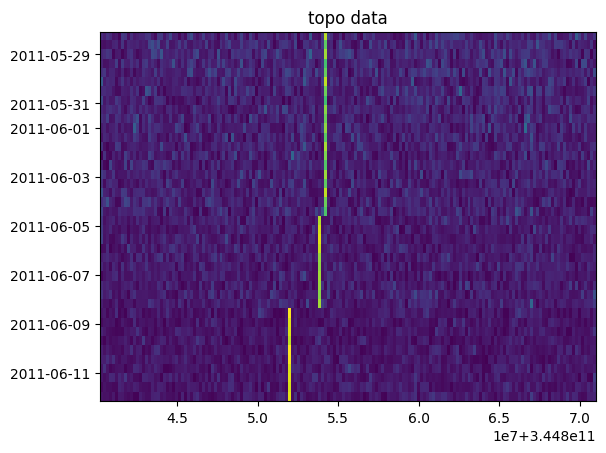

In [7]:
# Some visual
pl.figure()
pl.imshow(
    np.abs(origms.VISIBILITY.data[20:60, 0, :, 0]),
    extent=[origfreq[0], origfreq[-1], tas[-1].datetime, tas[0].datetime],
    aspect="auto",
    interpolation="none",
)
pl.title("topo data")



Let's show the same baseline warfall plot after astroviper cvel

Text(0.5, 1.0, 'astroviper cvel')

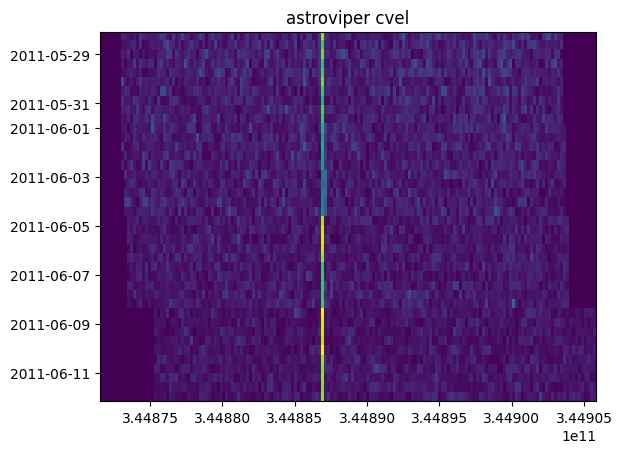

In [8]:
pl.figure()
finalfreq = lsrkms.frequency.data
pl.imshow(
    np.abs(lsrkms.VISIBILITY.data[20:60, 0, :, 0]),
    extent=[
        finalfreq[0],
        finalfreq[-1],
        tas[-1].datetime,
        tas[0].datetime,
    ],
    aspect="auto",
    interpolation="none",
)
pl.title("astroviper cvel")

Here is what casa cvel gives for the same baseline and comparison of the spectral plot for 1 time of casa and astroviper 

/Users/jsteeb/miniforge3/envs/zinc/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jsteeb/miniforge3/envs/zinc/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


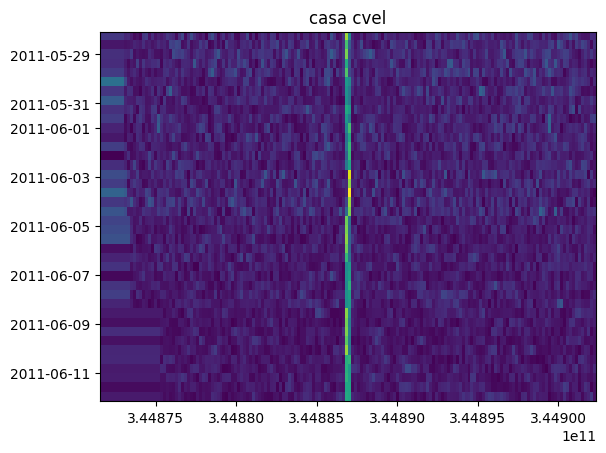

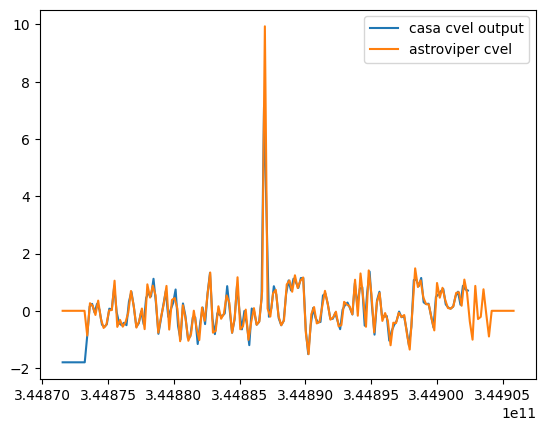

In [9]:
pl.figure()
ps_casalsrk_xdt = xr.open_datatree("Antennae_fld1_casa_lsrk.ps.zarr")
casams = ps_casalsrk_xdt["Antennae_fld1_casa_lsrk_0"]
casafreq = casams.frequency.data
pl.imshow(
    np.abs(casams.VISIBILITY.data[20:60, 0, :, 0]),
    extent=[casafreq[0], casafreq[-1], tas[-1].datetime, tas[0].datetime],
    aspect="auto",
    interpolation="none",
)
pl.title("casa cvel")
pl.figure()
pl.plot(
    casams.frequency,
    casams.VISIBILITY[40, 0, :, 0],
    label="casa cvel output",
)
pl.plot(
    lsrkms.frequency,
    lsrkms.VISIBILITY[40, 0, :, 0],
    label="astroviper cvel",
)
pl.legend()